[1] -0.5  1.2

(Intercept)           x 
 -0.5626744   0.8956781

(Intercept)           x 
 -0.5037637   1.2590350

29.25033
214.87294


,mean,bias,rmse
MLE beta0,-0.561,-0.061,0.087
MLE beta1,0.845,-0.355,0.370
ROB beta0,-0.484,0.016,0.068
ROB beta1,1.281,0.081,0.104


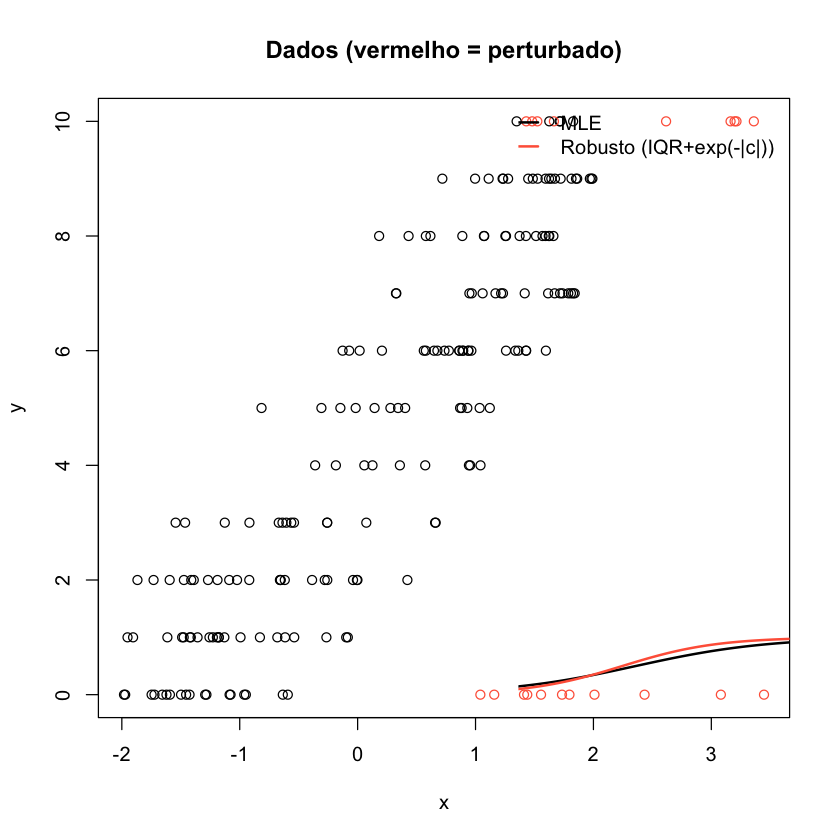

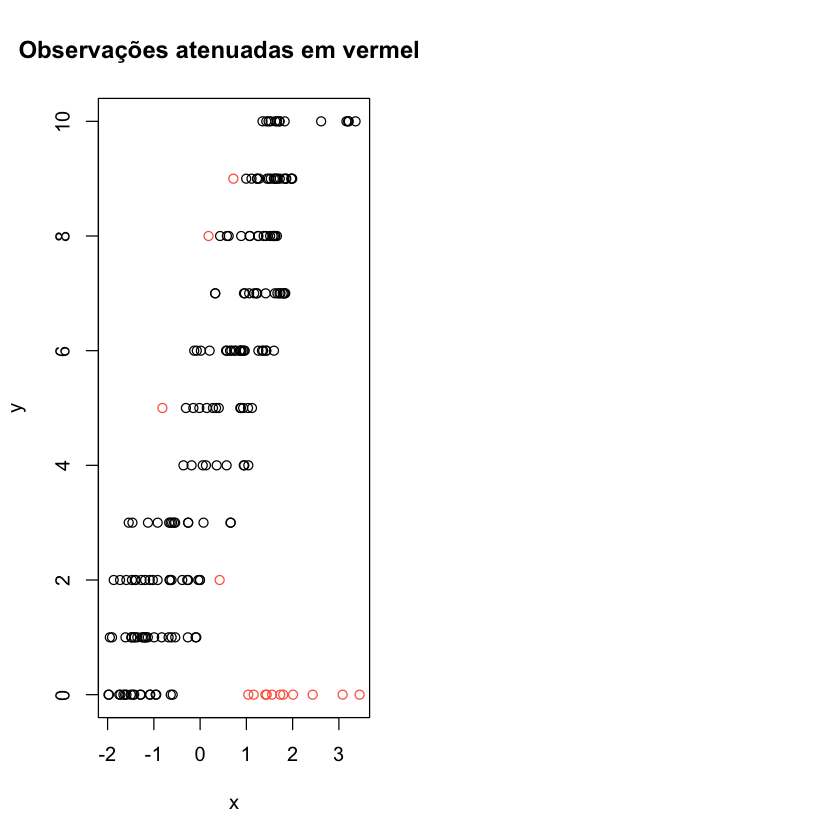

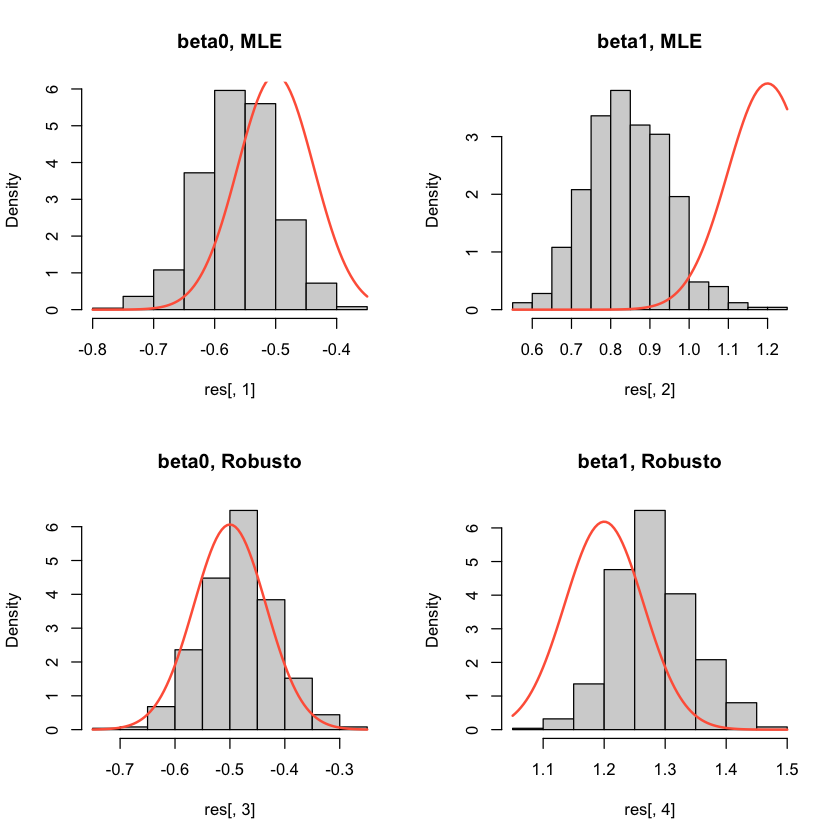

In [ ]:
## ===========================
##  REGRESSÃO BINOMIAL ROBUSTA
## ===========================

expit = function(eta) 1/(1+exp(-eta))

set.seed(2025)

## ---------------------------
## Exemplo único (com ruído)
## ---------------------------
n = 200
m = rep(10, n)
x = runif(n, -2, 2)

alpha = -0.5
beta  =  1.2
theta = c(alpha, beta)

mu = expit(theta[1] + theta[2]*x)
y  = rbinom(n, size=m, prob=mu)

## contaminação (alavanca x e rótulos 0/m), igual sala
aux = sample(which(x < 0.5), round(0.10*n))
x[aux] = x[aux] + 3
y[aux] = ifelse(runif(length(aux)) < 0.5, 0, m[aux])

plot(y ~ x, col=ifelse(1:n %in% aux, "tomato", "black"), main="Dados (vermelho = perturbado)")

## MLE (referência)
fit0 = glm(cbind(y, m - y) ~ x, family=binomial())
theta.hat0 = coef(fit0)

## -------- método robusto (IQR + exp(-|c|)) --------
## p como na lousa
p = 1.5

## Equações de estimação empilhadas
L = function(theta){
  eta = theta[1] + theta[2]*x
  mu  = expit(eta)
  r   = (y - m*mu)                         # resíduo "cru" estilo Poisson da aula
  cut = p * IQR(r)
  c_p = ifelse(abs(r) > cut, exp(-abs(r)), 1)  # atenuação
  cbind( c_p*(y - m*mu),
         c_p* x*(y - m*mu) )
}

## Norma^2 das equações (para o optim), igual ao “LL” do prof
LL = function(theta){
  u = colSums(L(theta))
  sum(u^2)
}

## Sandwich no estilo da lousa (B e V)
B = function(theta){
  U = L(theta)
  t(U) %*% U / n
}
V = function(theta){
  eps = 1e-6
  U0  = colSums(L(theta))
  J   = matrix(NA_real_, 2, 2)
  for(j in 1:2){
    th = theta
    th[j] = th[j] + eps
    Uj = colSums(L(th))
    J[, j] = (Uj - U0)/eps
  }
  solve(J) %*% B(theta) %*% t(solve(J))
}

## inicializa em MLE e otimiza
fit1 = optim(LL, par=theta.hat0, control=list(reltol=1e-12))
theta.hat1 = fit1$par
V.hat = V(theta.hat1)

## padronização com autovetores (mesmo teatrinho V_0.5 e W1)
E = eigen(V.hat)
V_0.5 = E$vectors %*% diag(1/sqrt(E$values)) %*% t(E$vectors)
W1 = sqrt(n) * V_0.5 %*% (theta.hat1 - theta)

par(mfrow=c(1,2))
## curva MLE vs Robusta
xs = seq(min(x), max(x), length.out=200)
lines(xs, expit(theta.hat0[1] + theta.hat0[2]*xs), lwd=2, col="black")
lines(xs, expit(theta.hat1[1] + theta.hat1[2]*xs), lwd=2, col="tomato")
legend("topleft", c("MLE","Robusto (IQR+exp(-|c|))"), col=c("black","tomato"), lwd=2, bty="n")

## marca quem foi atenuado pelo corte atual em vermelho
eta.r = theta.hat1[1] + theta.hat1[2]*x
r.now = (y - m*expit(eta.r))
cut.now = p * IQR(r.now)
plot(y ~ x, col=ifelse(abs(r.now) > cut.now, "tomato", "black"),
     main="Observações atenuadas em vermelho")

theta       ## verdadeiro
theta.hat0  ## MLE
theta.hat1  ## Robusto
W1          ## vetor padronizado

## ---------------------------
##   Monte Carlo
## ---------------------------
mc_binom_iqrexp = function(R=500, n=200, contam=0.10, p=1.5){
  out = matrix(NA_real_, R, 4)
  colnames(out) = c("b0_mle","b1_mle","b0_rob","b1_rob")
  m = rep(10, n)
  for(t in 1:R){
    x = runif(n, -2, 2)
    mu = expit(theta[1] + theta[2]*x)
    y  = rbinom(n, size=m, prob=mu)
    ## contamina igual ao exemplo
    aux = sample(which(x < 0.5), round(contam*n))
    x[aux] = x[aux] + 3
    y[aux] = ifelse(runif(length(aux)) < 0.5, 0, m[aux])

    ## MLE
    b_mle = coef(glm(cbind(y, m - y) ~ x, family=binomial()))

    ## robusto: mesmo L/LL com p-IQR e exp(-|c|)
    L = function(th){
      eta = th[1] + th[2]*x
      mu  = expit(eta)
      r   = y - m*mu
      c   = p * IQR(r)
      exc = pmax(0, abs(r) - c)
      w   = exp(-exc)
      cbind( w*(y - m*mu),
             w*x*(y - m*mu) )
    }
    LL = function(th){ u = colSums(L(th)); sum(u^2) }

    b_rob = try(optim(LL, par=b_mle, control=list(reltol=1e-12))$par, silent=TRUE)
    if(inherits(b_rob, "try-error")) next
    out[t,] = c(b_mle[1], b_mle[2], b_rob[1], b_rob[2])
  }
  out
}

set.seed(99)
res = mc_binom_iqrexp(R=500, n=200, contam=0.10, p=1.5)

summ = function(v, tru) c(mean=mean(v, na.rm=TRUE),
                         bias=mean(v-tru, na.rm=TRUE),
                         rmse=sqrt(mean((v-tru)^2, na.rm=TRUE)))
TAB = rbind(
  "MLE beta0" = summ(res[,1], theta[1]),
  "MLE beta1" = summ(res[,2], theta[2]),
  "ROB beta0" = summ(res[,3], theta[1]),
  "ROB beta1" = summ(res[,4], theta[2])
)
round(TAB, 3)

par(mfrow=c(2,2))
hist(res[,1], prob=TRUE, main="beta0, MLE");  curve(dnorm(x, mean(theta[1]), sd(res[,1],na.rm=TRUE)), add=TRUE, col="tomato", lwd=2)
hist(res[,2], prob=TRUE, main="beta1, MLE");  curve(dnorm(x, mean(theta[2]), sd(res[,2],na.rm=TRUE)), add=TRUE, col="tomato", lwd=2)
hist(res[,3], prob=TRUE, main="beta0, Robusto"); curve(dnorm(x, mean(theta[1]), sd(res[,3],na.rm=TRUE)), add=TRUE, col="tomato", lwd=2)
hist(res[,4], prob=TRUE, main="beta1, Robusto"); curve(dnorm(x, mean(theta[2]), sd(res[,4],na.rm=TRUE)), add=TRUE, col="tomato", lwd=2)

[1] -0.5  1.2

(Intercept)           x 
 -0.5626744   0.8956781

(Intercept)           x 
 -0.4856487   1.2480537

78.65897
184.73299


,mean,bias,rmse
MLE beta0,-0.561,-0.061,0.087
MLE beta1,0.845,-0.355,0.370
ROB beta0,-0.484,0.016,0.068
ROB beta1,1.281,0.081,0.104


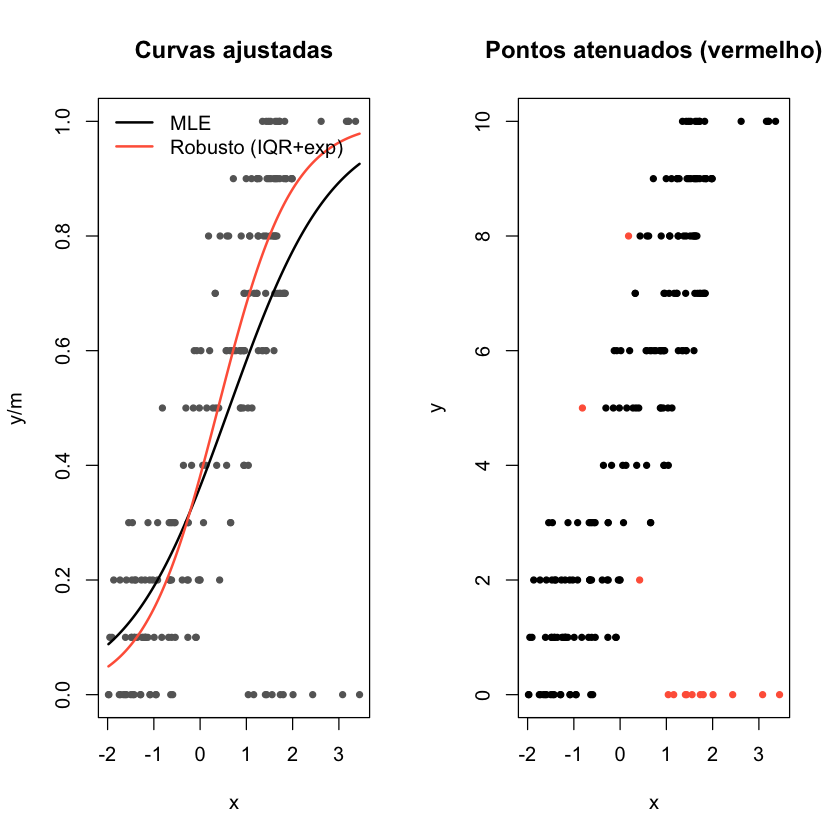

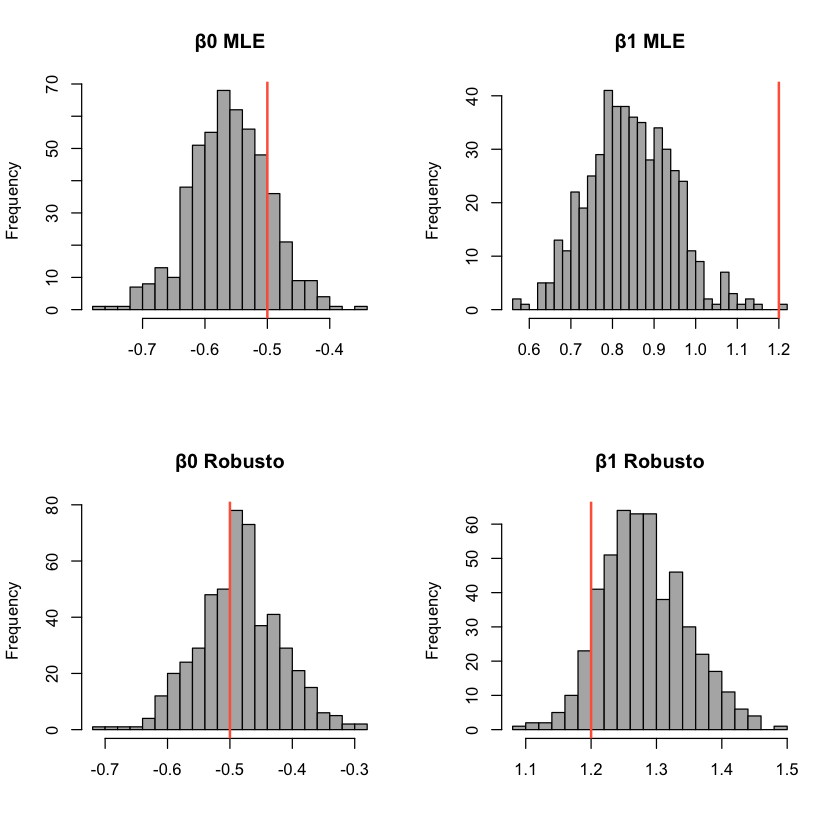

In [ ]:
## ======================================
##  Regressão Binomial Robusta (IQR + exp(-(|r|-c)_+))
##  Estilo das aulas do prof.
## ======================================

expit = function(eta) 1/(1+exp(-eta))
set.seed(2025)

## -----------------------------
## Exemplo único
## -----------------------------
n = 200
m = rep(10, n)
x = runif(n, -2, 2)

theta = c(-0.5, 1.2)
mu = expit(theta[1] + theta[2]*x)
y  = rbinom(n, size=m, prob=mu)

## contaminação (mesmo padrão de sala)
aux = sample(which(x < 0.5), round(0.10*n))
x[aux] = x[aux] + 3
y[aux] = ifelse(runif(length(aux)) < 0.5, 0, m[aux])

## estimador clássico
fit0 = glm(cbind(y, m - y) ~ x, family=binomial())
theta.hat0 = coef(fit0)

## ---------------------------------
## Função de estimação robusta
## ---------------------------------
p = 1.5

L = function(th){
  eta = th[1] + th[2]*x
  mu  = expit(eta)
  r   = y - m*mu
  c   = p * IQR(r)
  exc = pmax(0, abs(r) - c)
  w   = exp(-exc)
  cbind( w*(y - m*mu),
         w*x*(y - m*mu) )
}

LL = function(th){
  u = colSums(L(th))
  sum(u^2)
}

B = function(th){
  U = L(th)
  t(U) %*% U / n
}

V = function(th){
  eps = 1e-6
  U0  = colSums(L(th))
  J   = matrix(NA_real_, 2, 2)
  for(j in 1:2){
    thj = th
    thj[j] = thj[j] + eps
    Uj = colSums(L(thj))
    J[, j] = (Uj - U0)/eps
  }
  solve(J) %*% B(th) %*% t(solve(J))
}

fit1 = optim(LL, par=theta.hat0, control=list(reltol=1e-12))
theta.hat1 = fit1$par
V.hat = V(theta.hat1)

E = eigen(V.hat)
V_0.5 = E$vectors %*% diag(1/sqrt(E$values)) %*% t(E$vectors)
W1 = sqrt(n) * V_0.5 %*% (theta.hat1 - theta)

## -----------------------------
## Visualização do exemplo
## -----------------------------
par(mfrow=c(1,2))
plot(y/m ~ x, pch=20, col="grey40", main="Curvas ajustadas")
xs = seq(min(x), max(x), length=200)
lines(xs, expit(theta.hat0[1] + theta.hat0[2]*xs), lwd=2, col="black")
lines(xs, expit(theta.hat1[1] + theta.hat1[2]*xs), lwd=2, col="tomato")
legend("topleft", c("MLE","Robusto (IQR+exp)"), col=c("black","tomato"), lwd=2, bty="n")

eta.r = theta.hat1[1] + theta.hat1[2]*x
r.now = y - m*expit(eta.r)
cut.now = p * IQR(r.now)
plot(y ~ x, col=ifelse(abs(r.now) > cut.now, "tomato", "black"),
     main="Pontos atenuados (vermelho)", pch=20)

theta      # verdadeiro
theta.hat0 # MLE
theta.hat1 # Robusto
W1

## ======================================
## Simulação Monte Carlo 
## ======================================

mc_binom_iqrexp = function(R=500, n=200, contam=0.10, p=1.5){
  out = matrix(NA_real_, R, 4)
  colnames(out) = c("b0_mle","b1_mle","b0_rob","b1_rob")
  theta = c(-0.5, 1.2)
  m = rep(10, n)
  for(t in 1:R){
    x = runif(n, -2, 2)
    mu = expit(theta[1] + theta[2]*x)
    y  = rbinom(n, size=m, prob=mu)

    ## contaminação
    aux = sample(which(x < 0.5), round(contam*n))
    x[aux] = x[aux] + 3
    y[aux] = ifelse(runif(length(aux)) < 0.5, 0, m[aux])

    ## MLE
    b_mle = coef(glm(cbind(y, m - y) ~ x, family=binomial()))

    ## robusto
    L = function(th){
      eta = th[1] + th[2]*x
      mu  = expit(eta)
      r   = y - m*mu
      c   = p * IQR(r)
      exc = pmax(0, abs(r) - c)
      w   = exp(-exc)
      cbind( w*(y - m*mu),
             w*x*(y - m*mu) )
    }
    LL = function(th){ u = colSums(L(th)); sum(u^2) }
    b_rob = try(optim(LL, par=b_mle, control=list(reltol=1e-12))$par,
                silent=TRUE)
    if(inherits(b_rob, "try-error")) next
    out[t,] = c(b_mle[1], b_mle[2], b_rob[1], b_rob[2])
  }
  out
}

set.seed(99)
res = mc_binom_iqrexp(R=500, n=200, contam=0.10, p=1.5)

summ = function(v, tru) c(mean=mean(v,na.rm=TRUE),
                         bias=mean(v-tru,na.rm=TRUE),
                         rmse=sqrt(mean((v-tru)^2,na.rm=TRUE)))
TAB = rbind(
  "MLE beta0" = summ(res[,1], -0.5),
  "MLE beta1" = summ(res[,2],  1.2),
  "ROB beta0" = summ(res[,3], -0.5),
  "ROB beta1" = summ(res[,4],  1.2)
)
round(TAB, 3)

## -----------------------------
## Plots dos resultados MC
## -----------------------------
par(mfrow=c(2,2))
hist(res[,1], breaks=25, col="grey70", main="β0 MLE", xlab="")
abline(v=-0.5, col="tomato", lwd=2)
hist(res[,2], breaks=25, col="grey70", main="β1 MLE", xlab="")
abline(v=1.2, col="tomato", lwd=2)
hist(res[,3], breaks=25, col="grey70", main="β0 Robusto", xlab="")
abline(v=-0.5, col="tomato", lwd=2)
hist(res[,4], breaks=25, col="grey70", main="β1 Robusto", xlab="")
abline(v=1.2, col="tomato", lwd=2)